## GRU를 이용한 텍스트 생성

문자 수: 60322
문자 수（중복없음）: 980
Epoch: 1/60  471/471  Error: 29.416875985241187
Seed: 이 산등에 올라서면 용연 동네는 저렇
이 산등에 올라서면 용연 동네는 저렇로 내 이 보의 계 이 바어 생았다. 그는 이 나 소어 사리고 듯다.
이 그는 자 하고 들어 후 그의 사어.
그는 모의 생에 것이 어 한 일어 보을 나 그는 가 가 말을 말고 내 비 지을 이 부여 수의 아려는 한 보면 집 하고 생편 무지 눈 내에 방 일었다.
옥 그는 가 자어 말다.
이리고 들어 보의 있다.
그 불어 내려의 어어 보비는 하달 여지 사다.
그

Epoch: 2/60  471/471  Error: 27.144088748284275
Seed: 이 산등에 올라서면 용연 동네는 저렇
이 산등에 올라서면 용연 동네는 저렇게 손을 하여 지 하는 보다.
그의 어머니다. 그의 줄 이 같이 것이 어머니는 하니 일어나 바라보았다.
이 보르는 생각하고 그의 바문 그 들어 보았다. 
그는 어머니는 그리고 한 것이다.
이렇게 그러 그는 매을 가라보았다. 그리고 이 더에서 안을 일어가 보았다.
이렇게 지 이 앉으로 서 바라가 어머니는 받려에 어머니는 얼어 들어서 않게 이 오는 보았다.
이

Epoch: 3/60  471/471  Error: 26.75618855762375
Seed: 이 산등에 올라서면 용연 동네는 저렇
이 산등에 올라서면 용연 동네는 저렇게 그리고 가 보았다. 그리고 자 집에 선비가 선비가 사람하였다.
그는 이 방에 무슨 주려니 달았다.
그러나 그 안 생각하였다. 그리고 이 것이 그 들어 있다.
신철이는 잡 하였다.
덕호는 옥점이는 그 어머니 않는 것을 하였다.
그러고 무 방 가지 않고 것이 그리고 그 또 웃으로 모양이 모니 달아 보았다.
그리고 그 나무 그 사람이 안 바라보았다.
그 어머

Epoch: 4/60  471/471  Error: 24.715309154493852
Seed: 이 산등에 올라서면 용연 동네는 저렇
이 산등에 올

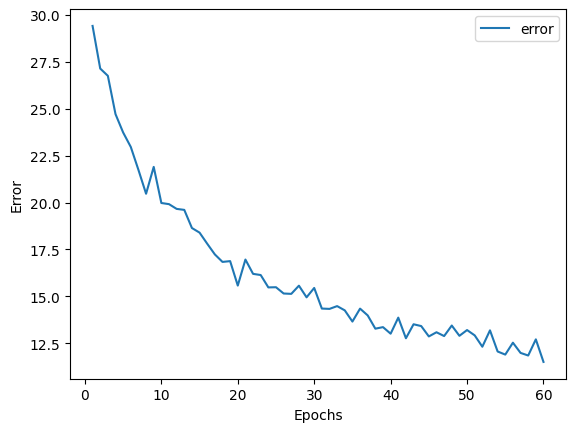

In [1]:
import numpy as np
# import cupy as np  # GPU를 사용하면 주석 해제
import matplotlib.pyplot as plt

# -- 각 설정값 --
n_time = 20 # 시점의 수
n_mid = 128 # 은닉층 뉴런 수
eta = 0.01 # 학습률
clip_const = 0.02 # 노름의 최대값을 구하는 상수
beta = 2 # 확률분포 폭（다음 시점의 문자를 예측할 때 사용）

epoch = 60
batch_size = 128

def sigmoid(x):
    return 1/(1+np.exp(-x))

def clip_grad(grads, max_norm): # common/functions.py 코드
    norm = np.sqrt(np.sum(grads*grads))
    r = max_norm / norm
    if r < 1:
        clipped_grads = grads * r
    else:
        clipped_grads = grads
    return clipped_grads

# -- 훈련용 텍스트 --
# 파일 읽어들이기
with open("human_problem.txt", mode="r", encoding="utf-8-sig") as f: # 저장소에 넣고, 파일명만 넣으면 됨 
 text = f.read()
print("문자 수:", len(text)) # len()으로 문자열의 문자 수도 출력 가능

# -- 문자와 인덱스 연결 --
chars_list = sorted(list(set(text)))  # set으로 문자 중복 제거
n_chars = len(chars_list)
print("문자 수（중복없음）:", n_chars)

char_to_index = {} # 문자가 키고 인덱스가 값인 딕셔너리
index_to_char = {} # 인덱스가 키고 문자가 값인 딕셔너리
for i, char in enumerate(chars_list):
    char_to_index[char] = i
    index_to_char[i] = char
 
# --  시계열로 나열된 문자와 다음 차례 문자 --
seq_chars = []
next_chars = []
for i in range(0, len(text) - n_time):
    seq_chars.append(text[i: i + n_time])
    next_chars.append(text[i + n_time])

# -- 입력과 정답 원핫 인코딩으로 표시 --
input_data = np.zeros((len(seq_chars), n_time, n_chars), dtype=np.uint8)
correct_data = np.zeros((len(seq_chars), n_chars), dtype=np.uint8)
for i, chars in enumerate(seq_chars):
    correct_data[i, char_to_index[next_chars[i]]] = 1  # 정답을 원핫 인코딩으로 표시 --
    for j, char in enumerate(chars):
        input_data[i, j, char_to_index[char]] = 1  # 입력을 원핫 인코딩으로 표시      

# -- GRU층-- 
class GRULayer:
    def __init__(self, n_upper, n):
        # 파라미터 초깃값
        self.w = np.random.randn(3, n_upper, n) / np.sqrt(n_upper)  # 자비에르 초깃값
        self.v = np.random.randn(3, n, n) / np.sqrt(n)

    def forward(self, x, y_prev):
        a0 = sigmoid(np.dot(x, self.w[0]) + np.dot(y_prev, self.v[0]))   # 수정 게이트
        a1 = sigmoid(np.dot(x, self.w[1]) + np.dot(y_prev, self.v[1]))  # 리셋 게이트
        a2 = np.tanh(np.dot(x, self.w[2]) + np.dot(a1*y_prev, self.v[2])) # 새로운 기억
        self.gates = np.stack((a0, a1, a2))

        self.y = (1-a0)*y_prev + a0*a2  # 출력
    
    def backward(self, x, y, y_prev, gates, grad_y):
        a0, a1, a2 = gates

       # 새로운 기억
        delta_a2 = grad_y * a0 * (1-a2**2)
        self.grad_w[2] += np.dot(x.T, delta_a2)
        self.grad_v[2] += np.dot((a1*y_prev).T, delta_a2)

       # 수정 게이트
        delta_a0 = grad_y * (a2-y_prev) * a0 * (1-a0)
        self.grad_w[0] += np.dot(x.T, delta_a0)
        self.grad_v[0] += np.dot(y_prev.T, delta_a0)

        # 리셋 게이트
        s = np.dot(delta_a2, self.v[2].T)
        delta_a1 = s * y_prev * a1 * (1-a1)
        self.grad_w[1] += np.dot(x.T, delta_a1)
        self.grad_v[1] += np.dot(y_prev.T, delta_a1)

        # x 기울기
        self.grad_x =  np.dot(delta_a0, self.w[0].T)
        + np.dot(delta_a1, self.w[1].T)
        + np.dot(delta_a2, self.w[2].T)

        # y_prev 기울기
        self.grad_y_prev = np.dot(delta_a0, self.v[0].T)
        + np.dot(delta_a1, self.v[1].T)
        + a1*s + grad_y*(1-a0)

    def reset_sum_grad(self):
        self.grad_w = np.zeros_like(self.w)
        self.grad_v = np.zeros_like(self.v)

    def update(self, eta):
        self.w -= eta * self.grad_w
        self.v -= eta * self.grad_v

    def clip_grads(self, clip_const):
        self.grad_w = clip_grad(self.grad_w, clip_const*np.sqrt(self.grad_w.size))
        self.grad_v = clip_grad(self.grad_v, clip_const*np.sqrt(self.grad_v.size))

# -- 전결합 출력층 --
class OutputLayer:
    def __init__(self, n_upper, n):
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)  # 자비에르 초깃값
        self.b = np.zeros(n)

    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = np.exp(u)/np.sum(np.exp(u), axis=1).reshape(-1, 1)   # 소프트맥스 함수

    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T) 

    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b

# -- 각 층의 초기화 --
gru_layer = GRULayer(n_chars, n_mid)
output_layer = OutputLayer(n_mid, n_chars)

# -- 훈련 --
def train(x_mb, t_mb):
   # 순전파 GRU층
    y_rnn = np.zeros((len(x_mb), n_time+1, n_mid))
    gates_rnn = np.zeros((3, len(x_mb), n_time, n_mid))
    y_prev = y_rnn[:, 0, :]
    for i in range(n_time):
        x = x_mb[:, i, :]
        gru_layer.forward(x, y_prev)

        y = gru_layer.y
        y_rnn[:, i+1, :] = y
        y_prev = y

        gates = gru_layer.gates
        gates_rnn[:, :, i, :] = gates

   # 순전파 출력층
    output_layer.forward(y)

    # 역전파 출력층
    output_layer.backward(t_mb)
    grad_y = output_layer.grad_x

    # 역전파 GRU층
    gru_layer.reset_sum_grad()
    for i in reversed(range(n_time)):
        x = x_mb[:, i, :]
        y = y_rnn[:, i+1, :]
        y_prev = y_rnn[:, i, :]
        gates = gates_rnn[:, :, i, :] 

        gru_layer.backward(x, y, y_prev, gates, grad_y)
        grad_y = gru_layer.grad_y_prev

   # 파라미터 갱신
    gru_layer.update(eta)
    output_layer.update(eta)

# -- 예측 --
def predict(x_mb):
    # 순전파 GRU층
    y_prev = np.zeros((len(x_mb), n_mid))
    for i in range(n_time):
        x = x_mb[:, i, :]
        gru_layer.forward(x, y_prev)
        y = gru_layer.y
        y_prev = y

   # 순전파 출력층
    output_layer.forward(y)
    return output_layer.y

# -- 오차 계산 --
def get_error(x, t):
    limit = 1000
    if len(x) > limit:   # 측정 샘플 수 최댓값 설정
        index_random = np.arange(len(x))
        np.random.shuffle(index_random)
        x = x[index_random[:limit], :]
        t = t[index_random[:limit], :]
    y = predict(x)
    return -np.sum(t*np.log(y+1e-7))/batch_size  # # 교차 엔트로피 오차

def create_text():
    prev_text = text[0:n_time]  # 입력
    created_text = prev_text  # 생성되는 텍스트
    print("Seed:", created_text)

    for i in range(200):   # 200자 문장 생성
         # 입력을 원핫 인코딩으로 표시
        x = np.zeros((1, n_time, n_chars))
        for j, char in enumerate(prev_text):
            x[0, j, char_to_index[char]] = 1
        
        # 다음 문자 예측
        y = predict(x)
        p = y[0] ** beta   # 확률분포 조정
        p = p / np.sum(p)  # p의 합을 1로
        next_index = np.random.choice(len(p), size=1, p=p)
        next_char = index_to_char[int(next_index[0])]
        created_text += next_char
        prev_text = prev_text[1:] + next_char

    print(created_text)
    print()   # 개행

error_record = []
n_batch = len(input_data) // batch_size  # 1에포크당 배치 개수
for i in range(epoch):
        
    # -- 학습 --
    index_random = np.arange(len(input_data))
    np.random.shuffle(index_random)  # 인덱스 임의 섞기
    for j in range(n_batch):
        
       # 미니 배치 구성
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x_mb = input_data[mb_index, :]
        t_mb = correct_data[mb_index, :]
        train(x_mb, t_mb)

       # -- 경과 표시 --
        print("\rEpoch: "+str(i+1)+"/"+str(epoch)+"  "+str(j+1)+"/"+str(n_batch), end="")

     # -- 오차 계산 --

    error = get_error(input_data, correct_data)
    error_record.append(error)
    print("  Error: "+str(error))

    # -- 경과 표시 --
    create_text()

plt.plot(range(1, len(error_record)+1), error_record, label="error")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend()
plt.show()